This notebook describes the power flow calculation. With it, power flows for hourly load data can be calculated. Alternatively, the results stored in the file 'results' can be used. For the sensitivity analysis, only the case where all households use a dynamic electricity tariff was investigated for different interval lengths (different sets of kappa)

### Requirements

Load the necessary packages to complete the power flow calculation with PandaPower.

In [1]:
import pandas as pd
import pandapower as pp
import pandapower.plotting as plot
from numpy import pi
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.networks as nw
import seaborn as sns

## Create Network using Kerber Dorfnetze

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


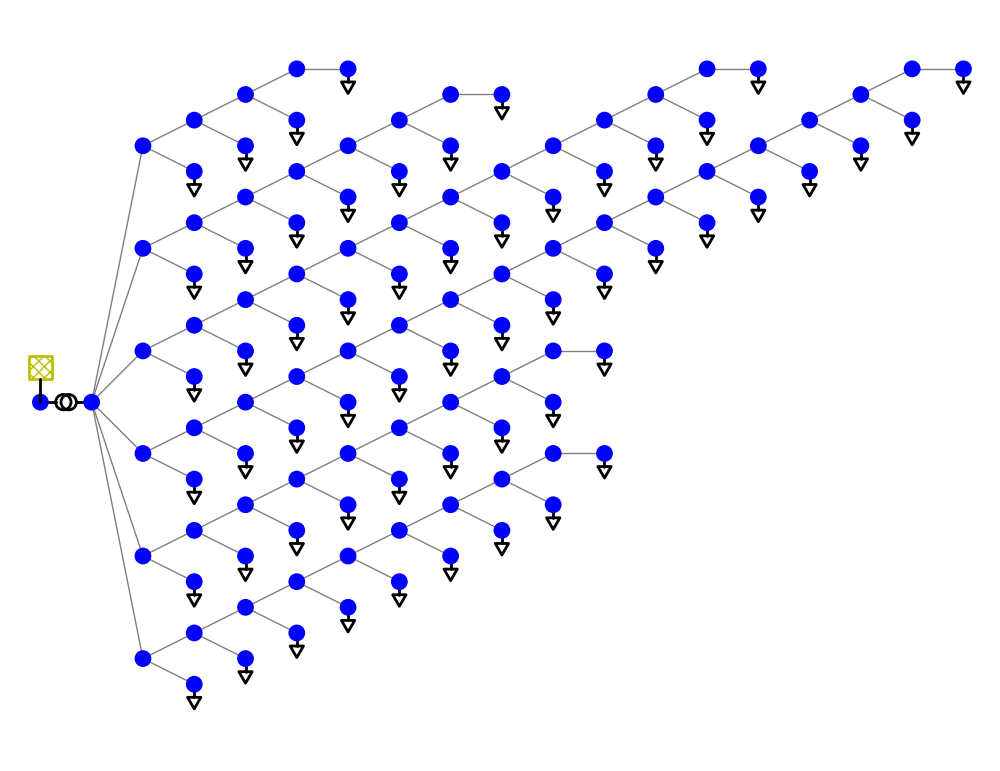

<Axes: >

In [2]:
net = nw.create_kerber_dorfnetz()
#plot to create artificial geodata
plot.simple_plot(net, plot_loads=True, load_size=1.0)

In [3]:
pp.runpp(net, max_iteration=20)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



### Load and Convert Data

In [4]:
#load data
load_before = pd.read_csv('load_before_shift.csv', index_col=0)
load_after = pd.read_csv('load_after_shift.csv', index_col=0)
time = pd.read_csv('Date.csv', index_col=0)
price = pd.read_csv('Hourly_Flexible_Prices.csv')

In [5]:
#convert loads from kWh to mWh
load_before_mwh = load_before/1000
load_after_mwh = load_after/1000

In [6]:
#randomly sample each household 2 or 3 times
import random
random.seed(1)

l = [i for i in range(22)]
l.extend([i for i in range(22)])
l.extend(random.sample(range(22), 13))

# Shuffle the list
random.shuffle(l)

Plot the count of each household in the network.

In [7]:
#Plot settings
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 12
#plt.style.use("seaborn-v0_8-white")
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.family'] = 'STIXGeneral'

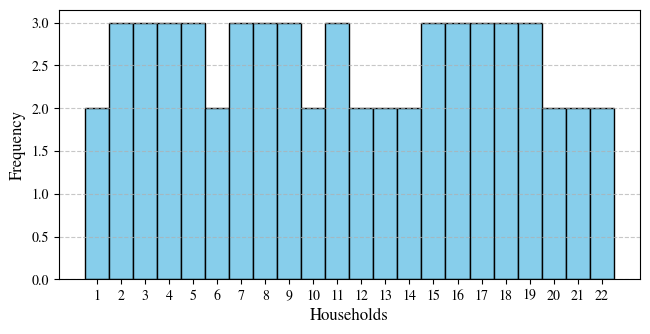

In [8]:
plt.subplots(figsize=(7.5, 3.5))
plt.hist(l, bins=range(0, 23), align='left', color='skyblue', edgecolor='black')
plt.xlabel('Households')
plt.ylabel('Frequency')
#plt.title('Distribution of Households in Network')
plt.xticks(range(0, 22),range(1,23) )
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('HHinKerberNetwork.png', bbox_inches='tight')
plt.show()

Determine which households use dynamic or flat electricity tariffs depending on the scenario and the proportion of households using dynamic tariffs.

In [9]:
random.seed(1)
indikator0flex = [0] * 57 #all households are using a flat electricity tariff
indikator25flex = [1] * 14 + [0] * 43 #75% of households are using a flat electricity tariff
indikator50flex = [1] * 29 + [0] * 28 #50% of households are using a flat electricity tariff
indikator75flex = [1] * 43 + [0] * 14 #25% of households arecusing a flat electricity tariff
indikator100flex = [1] * 57 #all households are using a dynamic electricity tariff

# Shuffle the list randomly
random.shuffle(indikator50flex)
random.shuffle(indikator25flex)
random.shuffle(indikator75flex)

#import to excel for an overview
indikatorDataFrame = pd.DataFrame()
indikatorDataFrame["25%"] = indikator25flex
indikatorDataFrame["50%"] = indikator50flex
indikatorDataFrame["75%"] = indikator75flex
indikatorDataFrame.to_excel('ShareOfHHUsingDynamic.xlsx', index=True)

### Calculate Power Flow

In [10]:
ds_b = DFData(load_before_mwh) #should be the load per time steps with flat electricity tariff
ds_a = DFData(load_after_mwh) #should be the load per time steps with dynamic electricity tariff
ts = range(len(load_before_mwh.index)) #number of all time steps
loadlist = load_before.columns.tolist()

In [11]:
#calculate network state at ervery time step
controls_b = []
for i in range(57):
    if indikator100flex[i] == 0:
        control = ConstControl(net, "load", element_index=net.load.index[i], variable="p_mw",
                           profile_name=loadlist[l[i]], data_source=ds_b)
    elif indikator100flex[i] == 1:
        control = ConstControl(net, "load", element_index=net.load.index[i], variable="p_mw",
                           profile_name=loadlist[l[i]], data_source=ds_a)
    controls_b.append(control)

ow_b = OutputWriter(net, time_steps= ts, output_path= "./resluts/results_100flex0flat/", output_file_type='.xlsx',)
ow_b.log_variable('res_bus', 'vm_pu') # add logging for bus voltage magnitudes
ow_b.log_variable('res_line', 'loading_percent') # add logging for line loadings in percent
ow_b.log_variable('res_trafo', 'loading_percent') #transformer loading

In [12]:
run_timeseries(net ,max_iteration=100, time_steps=ts, continue_on_divergence=True)

  0%|                                                                                         | 0/9504 [00:00<?, ?it/s]numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

100%|██████████████████████████████████████████████████████████████████████████████| 9504/9504 [04:13<00:00, 37.50it/s]
